In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import networkx as nx
np.set_printoptions(suppress=True)

random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed(9)

# Toy scenario

In [2]:
from causememaybe.toy import DiscreteToyProcess
from causememaybe.toy.discrete import beta_0_func, beta_1_func
from causememaybe.toy.visualise import plot_dataset, plot_treatment

n_samples = 5000
noise = 0.4
random_state = 9

In [3]:
dgp = DiscreteToyProcess(
                            n_samples=n_samples,
                            noise=noise,
                            random_state=random_state,
                            overlap="random",
                           )

Suppose we have a dataset. Where every patient's continious features are generated according to sklearn's [*make_moons*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) dataset. The classification label generated from this dataset is treated as a latent (unobserved) binary factor in our case denoted as $G \in \{0, 1\}$ - the idea is that it will confound our results. We plot this dataset below. 

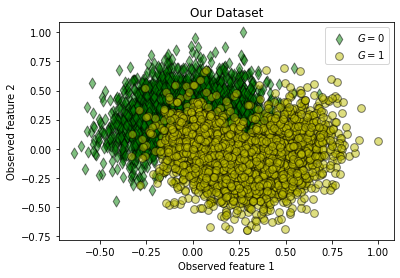

In [4]:
fig, ax = plot_dataset(dgp)

In our case we have a "subject" with continious features $X \in \mathcal{X}$, and unobserved categorical feature $G \in \{0, 1\}$. A subject could be a patient in the medical experiment or observational data, or an app user on facebook's platform.

### Treatment Assignment

#### Random Controlled Trial

Next we need to know what sort of treatment assignment we have in our data. If we are working with a randomized controlled trial (RCT), we know our treatment assignemnt $A$ will be random, and the propensity score will be 0.5 independent of the subjects covariates $X$. 

$
A \sim \text{Bernouli}(0.5)
$

we have the following plot that where marker shape shows latent variable value and color shows treatment assignment in the figure on the left. The figure on the right illiustrates how concentrated the propensity score is for both treated and control.

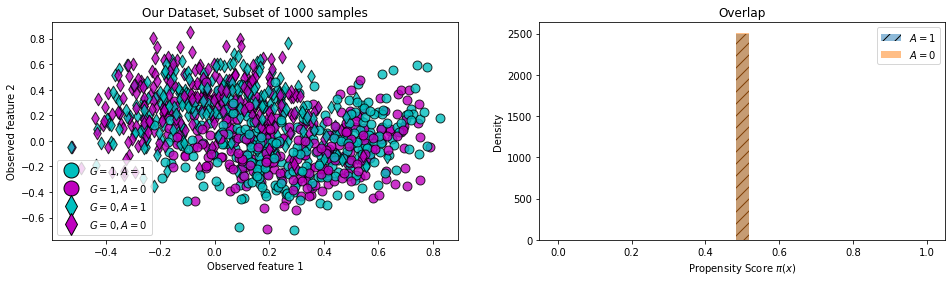

In [5]:
fig, axes = plot_treatment(dgp)

#### Observational Dataset

Now what is propensity score? A propensity score $\pi(x)$ is the probability of a unit (e.g., person, classroom, school) being assigned to a particular treatment given a set of observed covariates, namely:

$
\pi(x)= \mathbb{P}_\theta (A = 1 | X = x)
$

In essence, $\pi$ is the treatment assignment mechanism. In our case, we assume that in our observational dataset doctors had some partial knowledge about the underlying features $X$ and $G$ of the patients, and were able to some extend group them. We model it as a linear relationship between the patient's observed features $X$ and the log-odds (also called logit) of the $G=1$, which is a linear logistic regression $\text{sigmoid}(\beta_0 + \beta_1 x_1 + \beta_2 x_2)$. $\beta_0$ is set to have approximately 0.5 proportion of treated. $(\beta_1, \beta_2) = (1.18 \gamma, -1.76 \gamma)$, where $\gamma \in \{0.5, 1, 4 \}$ for strong, moderate and weak overlap. The higher is the overlap, the better are the doctors in determining the unobserved confounder $G$.

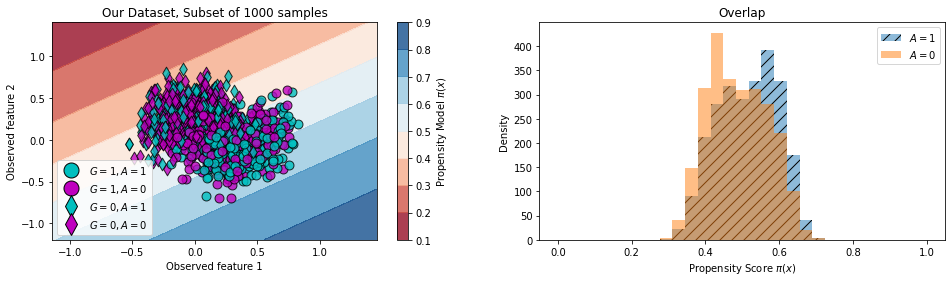

In [6]:
dgp_strong_overlap = DiscreteToyProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            overlap="strong",
                           )
fig, axes = plot_treatment(dgp_strong_overlap)

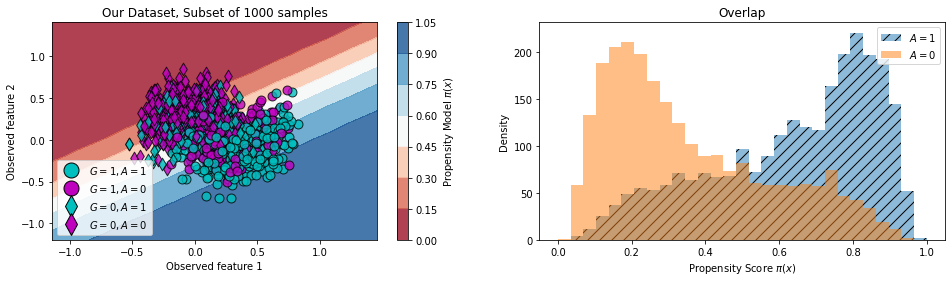

In [7]:
dgp_moderate_overlap = DiscreteToyProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            overlap="moderate",
                           )
fig, axes = plot_treatment(dgp_moderate_overlap)

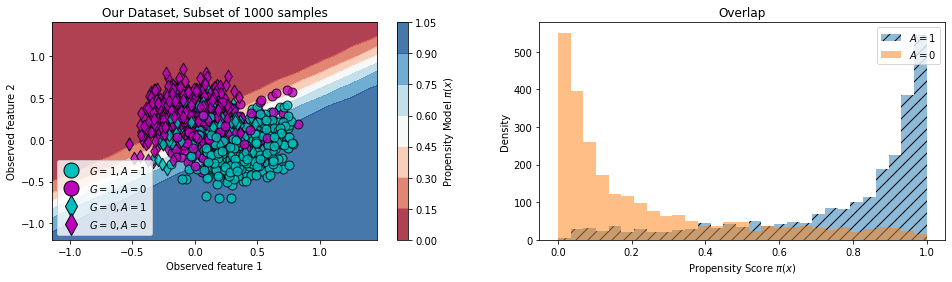

In [8]:
dgp_weak_overlap = DiscreteToyProcess(
                            n_samples=n_samples, 
                            noise=noise, 
                            random_state=random_state, 
                            overlap="weak",
                           )
fig, axes = plot_treatment(dgp_weak_overlap)

Later, we will cover the significance of overlap.

$A \in \{0, 1\}$ denotes a treatment variable, in this case we have only two treatment options: $A=0$ for no treatment, or control; and $A=1$ to indicate that a subject has been assigned to a treatment (e.g. new feature in an app, or hemeotherapy for a patient). 

### Binary outcome variable

The outcome variable $Y \in \{0, 1 \}$, is the outcome that we have actually observed in the experiment for a particular subject. The observed outcome $Y$ takes on values of either of the two "potential outcomes" $Y_{A=1}$ or $Y_{A=0}$ which depends on the value that $A$ takes, $Y = AY_{A=1} + (1-A)Y_{A=0}$.

In this work we generate binary outcomes from a Beta-Bernouli model. 

$
Y_{A} \sim \text{Bernoili}( \min[\rho + 0.2G, 1]), \text{ where } \rho \sim \text{Beta}(\alpha_{A}, \beta_{B})
$

$\alpha_{A=0} = 2$ and $\alpha_{A=1} = 5$ are shape parameters $\alpha > 0$. And $\beta_{A}$ are functions of subject features.

$
\beta_{A=0} = \exp(0.7 - 0.3 X_1 + 0.8 X_2) \\
\beta_{A=1} = \exp(0.9 - 0.5 X_1 + 0.5 X_2)
$

Number of positive outcomes in A=0: 1677; and in A=1: 2696


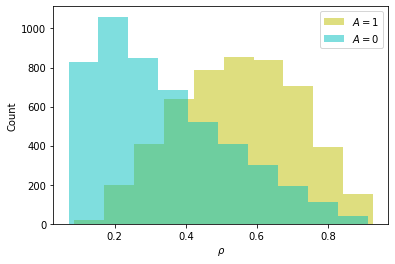

In [5]:
Y_1, rho_1, mu_1 = dgp.sample_outcomes("test")
Y_0, rho_0, mu_1 = dgp.sample_outcomes("control")
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(rho_1, label="$A = \\mathdefault{1}$", color="y", alpha=0.5);
ax.hist(rho_0, label="$A = \\mathdefault{0}$", color="c", alpha=0.5);
ax.legend();
ax.set_xlabel(r"$\rho$");
ax.set_ylabel("Count");
print("Number of positive outcomes in A=0: {}; and in A=1: {}".format(Y_0.sum(), Y_1.sum()))

### Data generation process recap

To recap we have the following: 

Observed features and latent binary factor generated from make moons function,

$
X, G \sim \text{sklearn make moons}
$

Treatment assignment for random controlled trial is:

$
A \sim \text{Bernouli}(0.5)
$

and for an observation study:

$
A \sim \text{Bernoili}(\pi(x)), \text{ where } \pi(x) = \text{Pr}(A=1|X=x)
$

Given the treatment assignment we generate factual survival time $Y_A$,

$
Y_{A} \sim \text{Bernoili}( \min[\rho + 0.2G, 1]), \text{ where } \rho \sim \text{Beta}(\alpha_{A}, \beta_{B})
$

which leads to observed outcome $Y$

$
Y = AY_{A=1} + (1-A)Y_{A=0}
$

### Causal graph

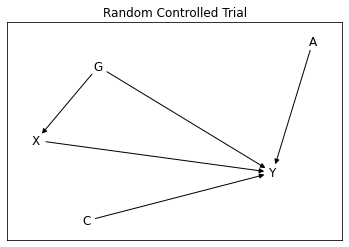

In [259]:
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('G', 'X'), ('G', 'Y'), ('C', 'Y'), ('X', 'Y'), ('A', 'Y')])
fig, ax = plt.subplots(figsize=(6,4));
nx.draw_networkx(G, arrows=True, node_color="white", ax=ax)
ax.set_title("Random Controlled Trial");

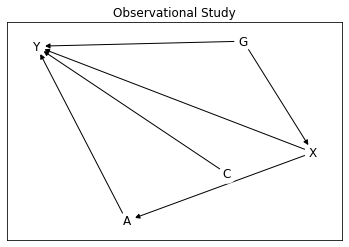

In [260]:
G = nx.DiGraph(directed=True)
G.add_edges_from(
    [('G', 'X'), ('G', 'Y'), ('C', 'Y'), ('X', 'Y'), ('A', 'Y'), ("X", "A")])
fig, ax = plt.subplots(figsize=(6,4));
nx.draw_networkx(G, arrows=True, node_color="white", ax=ax)
ax.set_title("Observational Study");

### Potential outcomes framework

The overall framework and notation we adopted above is referred to as _potential outcomes framework_ for modeling causal effects in observational and experimental studies. In our case we have a "subject" with continious features $X \in \mathcal{X}$, and unobserved categorical feature $G \in \{0, 1\}$. A subject could be a patient in the medical experiment or observational data, or an app user on facebook's platform. $A \in \{0, 1\}$ denotes a treatment variable, in this case we have only two treatment options: $A=0$ for no treatment, or control; and $A=1$ to indicate that a subject has been assigned to a treatment (e.g. new feature in an app, or hemeotherapy for a patient). The outcome variable $Y \in \{0, 1 \}$, is the outcome time that we have actually observed in the experiment for a particular subject. The observed outcome $Y$ takes on values of either of the two "potential outcomes" $Y_{A=1}$ or $Y_{A=0}$ which depends on the value that $A$ takes, hence $Y = AY_{A=1} + (1-A)Y_{A=0}$.

When working with observational data or data from a randomized control trials, we tipycally are given $N$ samples of the tuples $Z = (X, A, Y)$ (forgetting for a second that we may have some unobserved confounders $U$, in our case binary variable $G$). Samples $Z$ are drawn from some underlying probability distribution with paramters $\theta$

$
Z_1, ..., Z_n \sim \mathbb{P}_{\theta}
$

We may further breakdown $\theta$ into a collection a _nuissance_ paramters (paramters that are not of imediate interest but need to be accounted for):

$
\theta = \{ \mu_{A=1}, \mu_{A=0}, \pi, \eta \}
$

where $\mu_{A=1}(x) = \mathbb{E}_{\theta}[Y_{A=1}|X=x]$ and $\mu_{A=0}(x) = \mathbb{E}_{\theta}[Y_{A=0}|X=x]$ are conditional potential outcomes for a subject with features $x$. and $\pi$ is the treatment assignment mechanism,

$
\pi(x)= \mathbb{P}_\theta (A = 1 | X = x)
$

and $\eta(x) = \mathbb{P}_\theta (X=x)$. 

In the simulation above we have access to each of the steps of the data generative process, and we know that the treatment assignment is random.

Our goal is then to use causal inference techniques to infer the treatment effects function $\tau(X)$ of individual subjects based on their features using the samples $\{ Z_i \}^{N}_{i=1}$. The treatment effect function is defined as $\tau(X) = \mathbb{E}[Y_{A=1} - Y_{A=1} | X] = \mu_{A=1}(x) - \mu_{A=0}(x)$, known as Individual Treatment Effect (ITE). Our causal model $M$ maps a dataset $\{ Z_i \}^{N}_{i=1}$ to an estimate $\hat{\tau}(.)$ of ITE. The accuracy of the model is charaterised by the squarred-$L^2$ loss:

$
\epsilon_{PEHE} = || \hat{\tau}(X) - \tau(X) ||^{2}_\theta \approx \frac{1}{N} \sum^{N}_{n=1} || \hat{\tau}(X=x_n) - \tau(X=x_n) ||^{2}_\theta
$

also known as Precision of Estimating Heterogeneous Effects (PEHE), where $||f(X)||^{2}_\theta = \mathbb{E}_{\theta}[f^{2}(X)]$. 

Note that to estimate PEHE one has to have access to factual and counterfactual outcomes and their generative distribution, so that their expectations of the outcomes can be compared.

### Coming back to data

In [261]:
dgp.df.head(n=10)

,x0,x1,latent_binary_confounder,treatment_assignment,true_treatment_prob,y_test,y_control,mu_test,mu_control,rho_test,rho_control,observed
0,0.175632,0.651367,0,0,0.5,1,0,0.490187,0.242712,0.533770,0.214027,0.0
1,-0.331225,-0.264673,0,0,0.5,1,1,0.541240,0.282261,0.571860,0.545779,1.0
2,0.243493,-0.167557,1,1,0.5,1,0,0.599681,0.333038,0.903922,0.243055,1.0
3,-0.038084,0.503672,0,0,0.5,0,0,0.481941,0.236696,0.355416,0.099319,0.0
4,0.139760,0.193171,0,1,0.5,1,0,0.542871,0.283594,0.704115,0.020853,1.0
5,0.442344,0.065242,0,1,0.5,1,0,0.595600,0.329279,0.378543,0.078001,1.0
6,0.064051,0.095395,1,0,0.5,1,0,0.545608,0.285841,0.839710,0.362123,0.0
7,0.244254,-0.276760,1,1,0.5,1,1,0.612805,0.345361,0.956571,0.631192,1.0
8,0.277913,0.339293,0,0,0.5,1,1,0.541882,0.282785,0.854790,0.110042,1.0
9,0.321900,0.036512,0,1,0.5,1,0,0.584508,0.319231,0.275238,0.182744,1.0


We can see our continious features $X$ as `x0` and `x1`; latent confounder $G$ as `latent_binary_confounder`; treatment assignment indicator; conditional potential outcomes $\mu_{A=1}(x)$ and $\mu_{A=0}(x)$ denoted as `mu_test` and `mu_control`; and the corresponding sampled potential outcomes `y_test` and `y_control`, and the observed outcome `observed`.

In [262]:
print("% of treated subjects: {}".format(dgp.df.treatment_assignment.sum()/len(dgp.df)*100))

% of treated subjects: 49.8


In [263]:
rho_given_x_true = dgp.df.mu_test - dgp.df.mu_control
avg_rho_true = np.sum(rho_given_x_true) / len(dgp.df)
print("Average true Treatment Effect: {:.3f}".format(avg_rho_true))

Average true Treatment Effect: 0.259


### Simplest method

We could directly use conditional regression or classification to estimate $\tau(X) = \mathbb{E}[Y_{A=1} - Y_{A=1} | X] = \mu_{A=1}(x) - \mu_{A=0}(x)$, i.e. learning $\mu_{A=1}(x)$ and $\mu_{A=0}(x)$, to get:

$
\hat{\tau}(X) = \hat{\mu}_{A=1}(x) - \hat{\mu}_{A=0}(x)
$

This approach is also referred to as T-Learner [(Alaa et al. (2019))](http://proceedings.mlr.press/v97/alaa19a.html) or Q-Learning [Qian & Murphy (2011)](https://projecteuclid.org/euclid.aos/1304947047). However, this estimate might be biased and is different estimation task to standard ML problems because the two conditional expectations have to be estimated in different, treatment-specific subsamples - ML methods attempt to maximise out-of-sample predictive power of the two estimators separately (See [Lechner et al (2019)](https://arxiv.org/pdf/1812.09487.pdf) for discussion, builds on Athey's work and addresses the issue). This problem can be particularly pronounced when the features are highly predictive for $Y$, but the ITE are rather constant.

Some literature like Shalit et al (2017) and Johansson et al (2018) attempt to match the distributions inspired by domain adaptation literature. However, as [Zhang et al. (2020)](http://proceedings.mlr.press/v108/zhang20c/zhang20c.pdf) recently showed, this does not work as expected, and proposed an alternative.

In [264]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_predict

In [267]:
def conditional_outcome(dgp):
    
    rho_given_x_true = dgp.df.mu_test - dgp.df.mu_control
    avg_rho_true = np.sum(rho_given_x_true) / len(dgp.df)

    x = dgp.X
    a = dgp.df['treatment_assignment'].values.astype(np.int32)
    y = dgp.df['observed']
    
    mu_0 = np.zeros(y.shape)
    mu_1 = np.zeros(y.shape)

    a_0_ind = np.where(a == 0)[0]
    a_1_ind = np.where(a == 1)[0]
    
    #### Learn mu_0
    # First predict using cross val for in sample data A=0
    mu_0[a_0_ind] = cross_val_predict(RandomForestClassifier(), 
                                      x[a_0_ind], y[a_0_ind], method='predict_proba')[:,1]
    # Then train on in sample A=0 data and predict out of sample A=1
    mu_0[a_1_ind] = RandomForestClassifier().fit(x[a_0_ind], y[a_0_ind]).predict_proba(x[a_1_ind])[:,1]
    
    #### Learn mu_1
    # First predict using cross val for in sample data A=1
    mu_1[a_1_ind] = cross_val_predict(RandomForestClassifier(), 
                                      x[a_1_ind], y[a_1_ind], method='predict_proba')[:,1]
    # Then train on in sample A=1 data and predict out of sample A=0
    mu_1[a_0_ind] = RandomForestClassifier().fit(x[a_1_ind], y[a_1_ind]).predict_proba(x[a_0_ind])[:,1]
    
    rho_hat = mu_1 - mu_0
    
    avg_rho_hat = np.mean(rho_hat)
    
    pehe = np.sqrt(np.sum((rho_given_x_true - rho_hat)**2) / len(rho_given_x_true))
    
    return avg_rho_true, avg_rho_hat, pehe

In [268]:
for process, overlap in [
    (dgp, "RCT, 'perfect'"), 
    (dgp_strong_overlap, "Strong"),
    (dgp_moderate_overlap, "Moderate"),
    (dgp_weak_overlap, "Weak")
    ]:
    avg_rho_true, avg_rho_hat, pehe = conditional_outcome(process)
    print("\n{} overlap".format(overlap))
    print("True average treatment effect: {:.4f}; \
          Estimated average treatment effect: {:.4f}".format(avg_rho_true, avg_rho_hat))
    print("Precision of Estimating Heterogeneous Effects (PEHE): {:.3f}".format(pehe))


RCT, 'perfect' overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.2534
Precision of Estimating Heterogeneous Effects (PEHE): 0.292

Strong overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.2586
Precision of Estimating Heterogeneous Effects (PEHE): 0.268

Moderate overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.2604
Precision of Estimating Heterogeneous Effects (PEHE): 0.272

Weak overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.2689
Precision of Estimating Heterogeneous Effects (PEHE): 0.273


### Outcome Transformation Methods

#### Lai's transformation

A randomized study like the one we have simulated above allows us to draw conclusions about the treatment effect. This is because randomisation (at least in sufficiently large studies) ensures that other variables predicting $Y$ have the same distribution among treated ($A=1$) and controls ($A=0$). In other words, the treatment groups are _exchangeable_.

In such case Jaskowski et al. (2012) (originally introduced in Lai et al. (2006)) showed that one can use variable transformation, drawing inspiration from uplift modeling, to model the treatment effect. Let variable $Z \in \{0, 1\}$: 

$
Z^{LAI} = 
\begin{cases}
  1 \text{  if  } A=1 \text{  and  } Y=1\\      
  1 \text{  if  } A=0 \text{  and } Y=0\\
  0 \text{  otherwise }
\end{cases} 
$

or more elegantly:

$
Z^{LAI} = Y \cdot A + (1-Y)(1-A)
$

The predicted $\hat{Z}^{LAI}$ is a biased estimate of $\tau(x)$, which can be corrected via $\hat{\tau}(x)^{LAI}=2*\hat{Z}^{LAI}-1$.

In [242]:
def jaskowski_transformation(dgp):
    
    rho_given_x_true = dgp.df.mu_test - dgp.df.mu_control
    avg_rho_true = np.sum(rho_given_x_true) / len(dgp.df)

    dgp.df['Z'] = ((dgp.df['treatment_assignment'] == 1) & (dgp.df['observed'] == 1)) \
    | ((dgp.df['treatment_assignment'] == 0) & (dgp.df['observed'] == 0))

    x = dgp.X
    z = dgp.df['Z'].values.astype(np.int32)

    clf = RandomForestClassifier()
    z_hat = cross_val_predict(clf, x, z, method='predict_proba')[:,1]
    rho_hat = 2*z_hat-1 # Bias correction
    avg_rho_hat = np.mean(rho_hat)
    
    pehe = np.sqrt(np.sum((rho_given_x_true - rho_hat)**2) / len(rho_given_x_true))
    
    return avg_rho_true, avg_rho_hat, pehe

In [243]:
for process, overlap in [
    (dgp, "RCT, 'perfect'"), 
    (dgp_strong_overlap, "Strong"),
    (dgp_moderate_overlap, "Moderate"),
    (dgp_weak_overlap, "Weak")
    ]:
    avg_rho_true, avg_rho_hat, pehe = jaskowski_transformation(process)
    print("\n{} overlap".format(overlap))
    print("True average treatment effect: {:.4f}; \
          Estimated average treatment effect: {:.4f}".format(avg_rho_true, avg_rho_hat))
    print("Precision of Estimating Heterogeneous Effects (PEHE): {:.3f}".format(pehe))


RCT, 'perfect' overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.2539
Precision of Estimating Heterogeneous Effects (PEHE): 0.406

Strong overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.2908
Precision of Estimating Heterogeneous Effects (PEHE): 0.380

Moderate overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.3814
Precision of Estimating Heterogeneous Effects (PEHE): 0.394

Weak overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.4209
Precision of Estimating Heterogeneous Effects (PEHE): 0.421


The error in the ATE increases steadily as the overlap decreases. <font color='red'>PEHE on the other hand stays the same steadily, I believe this is due to bias introduced through my treatment assignment function - samples on either extremes of the mixtures have easily known response to treatment.</font>


#### IPW

In an observational study where treatment allocation is not under control (or non-random), as we considered above, the situation is different and a direct comparison of the distribution of $Y$ between treated and untreated may no longer be a fair one because of the _confounding_ effect arrising possibly from different distributions of $X$ in the treatment groups.

The transformation we used above, from Jankowski et al (2012) works well for clinical trials, where we have a perfect overlap i.e. treatment probability is exactly 0.5 for all observations; but it severally over-estimates treatment effect in observational studies. An alternative, non-biased approach comes from statistics community, Wooldridge’s (2001) book on panel data analysis:

$
Z^{IPW} = Y \cdot \frac{A}{\pi(x)} - Y \cdot \frac{(1-A)}{(1-\pi(x))}
$

which is equivalent to the transformation suggested by Athey and Imbens (2015), and also known as IPW. It requires us to first estimate propensities $\pi(x)$.

In [244]:
def wooldrige_transformation(dgp):
    
    rho_given_x_true = dgp.df.mu_test - dgp.df.mu_control
    avg_rho_true = np.sum(rho_given_x_true) / len(dgp.df)
    
    x = dgp.X
    a = dgp.df['treatment_assignment']
    
    clf = RandomForestClassifier()
    propensity = cross_val_predict(clf, x, a, method='predict_proba')[:,1]
    
    
    a = dgp.df['treatment_assignment']
    y = dgp.df['observed']
    z = y * (a / (propensity+1e-10)) - y * ((1-a)/(1 - propensity + 1e-10))
    
    filtered = np.where((z < 100) & (z > -100))[0] # filter out crazy values
    
    reg = RandomForestRegressor()
    rho_hat = cross_val_predict(reg, x[filtered,:], z[filtered], method='predict')
    avg_rho_hat = np.mean(rho_hat)

    pehe = np.sqrt(np.sum((rho_given_x_true[filtered] - rho_hat)**2) / len(rho_given_x_true[filtered]))

    return avg_rho_true, avg_rho_hat, pehe

In [245]:
for process, overlap in [
    (dgp, "RCT, 'perfect'"), 
    (dgp_strong_overlap, "Strong"),
    (dgp_moderate_overlap, "Moderate"),
    (dgp_weak_overlap, "Weak")
    ]:
    avg_rho_true, avg_rho_hat, pehe = wooldrige_transformation(process)
    print("\n{} overlap".format(overlap))
    print("True average treatment effect: {:.4f}; \
          Estimated average treatment effect: {:.4f}".format(avg_rho_true, avg_rho_hat))
    print("Precision of Estimating Heterogeneous Effects (PEHE): {:.3f}".format(pehe))


RCT, 'perfect' overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.3583
Precision of Estimating Heterogeneous Effects (PEHE): 1.009

Strong overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.3746
Precision of Estimating Heterogeneous Effects (PEHE): 1.516

Moderate overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.1155
Precision of Estimating Heterogeneous Effects (PEHE): 2.620

Weak overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.3064
Precision of Estimating Heterogeneous Effects (PEHE): 3.287


The IPW estimator exhibits a substantially high variance. Something that has been observed by [Powers et al. (2018)](https://arxiv.org/abs/1707.00102), due to potentially extreme values of the propensity score
in the denominator. 

#### Robins and Rotnitzky, doubly robust

Another outcome transformation approach is based on the doubly robust (DR) estimator of Robins and Rotnitzky (1995),

$
Z^{DR} = \mu_{A=1}(x) - \mu_{A=0}(x) + \frac{A \cdot (Y-\mu_{A=1}(x))}{\pi(x)} - \frac{(1-A) \cdot(Y-\mu_{A=0}(x))}{(1-\pi(x))}
$

Crucially, $\tau(x) = \mathbb{E}[Z^{IPW} | X=x] = \mathbb{E}[Z^{DR} | X=x]$. DR estimator however, requires estimating nuisance paramters such as $\mu_{A=1}$ and $\mu_{A=0}$ in addition to $\pi(x)$.

In [273]:
def doubly_robust_transformation(dgp):
    
    rho_given_x_true = dgp.df.mu_test - dgp.df.mu_control
    avg_rho_true = np.sum(rho_given_x_true) / len(dgp.df)

    x = dgp.X
    a = dgp.df['treatment_assignment'].values.astype(np.int32)
    y = dgp.df['observed']
    
    mu_0 = np.zeros(y.shape)
    mu_1 = np.zeros(y.shape)

    a_0_ind = np.where(a == 0)[0]
    a_1_ind = np.where(a == 1)[0]
    
    #### Learn mu_0
    # First predict using cross val for in sample data A=0
    mu_0[a_0_ind] = cross_val_predict(RandomForestClassifier(), 
                                      x[a_0_ind], y[a_0_ind], method='predict_proba')[:,1]
    # Then train on in sample A=0 data and predict out of sample A=1
    mu_0[a_1_ind] = RandomForestClassifier().fit(x[a_0_ind], y[a_0_ind]).predict_proba(x[a_1_ind])[:,1]
    
    #### Learn mu_1
    # First predict using cross val for in sample data A=1
    mu_1[a_1_ind] = cross_val_predict(RandomForestClassifier(), 
                                      x[a_1_ind], y[a_1_ind], method='predict_proba')[:,1]
    # Then train on in sample A=1 data and predict out of sample A=0
    mu_1[a_0_ind] = RandomForestClassifier().fit(x[a_1_ind], y[a_1_ind]).predict_proba(x[a_0_ind])[:,1]
    
    #### Learn Propensity model
    clf = RandomForestClassifier()
    propensity = cross_val_predict(clf, x, a, method='predict_proba')[:,1]
    
    #### Create the Z^{DR} variable
    z_dr = mu_1 - mu_0 + (a*(y-mu_1))/propensity - ((1-a)*(y-mu_1))/(1-propensity)
    
    filtered = np.where((z_dr < 100) & (z_dr > -100))[0] # filter out crazy values
    
    reg = RandomForestRegressor()
    rho_hat = cross_val_predict(reg, x[filtered,:], z_dr[filtered], method='predict')
    avg_rho_hat = np.mean(rho_hat)
            
    pehe = np.sqrt(np.sum((rho_given_x_true[filtered] - rho_hat)**2) / len(rho_given_x_true[filtered]))
    
    return avg_rho_true, avg_rho_hat, pehe

In [274]:
for process, overlap in [
    (dgp, "RCT, 'perfect'"), 
    (dgp_strong_overlap, "Strong"),
    (dgp_moderate_overlap, "Moderate"),
    (dgp_weak_overlap, "Weak")
    ]:
    avg_rho_true, avg_rho_hat, pehe = doubly_robust_transformation(process)
    print("\n{} overlap".format(overlap))
    print("True average treatment effect: {:.4f}; \
          Estimated average treatment effect: {:.4f}".format(avg_rho_true, avg_rho_hat))
    print("Precision of Estimating Heterogeneous Effects (PEHE): {:.3f}".format(pehe))


RCT, 'perfect' overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.5844
Precision of Estimating Heterogeneous Effects (PEHE): 1.009

Strong overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.6493
Precision of Estimating Heterogeneous Effects (PEHE): 1.336

Moderate overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.6265
Precision of Estimating Heterogeneous Effects (PEHE): 2.210

Weak overlap
True average treatment effect: 0.2586;           Estimated average treatment effect: 0.7246
Precision of Estimating Heterogeneous Effects (PEHE): 2.797


### Modified Covariate Methods

[Tian et al. (2014)](https://www.tandfonline.com/doi/full/10.1080/01621459.2014.951443?scroll=top&needAccess=true) inroduced the modified covariate method (MCM) suitable for RCTs with many covariates. [Chen et al. (2017)](https://onlinelibrary.wiley.com/doi/abs/10.1111/biom.12676) extended MCM to observational studies. As shown in [Knaus et al. (2018)](https://arxiv.org/pdf/1810.13237.pdf) MCM can be specified as an objective function for $\tau(x)$ (ITE) estimation, let $T = 2A-1 \in \{-1, 1\}$, then for continious outcome we can have the squarred loss function

$
\underset{\theta}{\arg \min} \Big[ \frac{1}{N} \sum^{N}_{i=1} \frac{(Y_i - T_i f{\theta}(x))^{2}}{T_i \pi(x) + (1-T_i)/2} \Big]
$

which implies a treatment effect $2f(x) = \mathbb{E}[Y_{A=1} | X=x, A=1] - \mathbb{E}[Y_{A=0} | X=x, A=0]$. Hence once an estimator $\hat{f}()$ is obtained, we can use $2\hat{f}(x)$ to approximate ITE.

For the outcome variable that is strictly positive:

$
\underset{\theta}{\arg \min} \Big[ \frac{1}{N} \sum^{N}_{i=1} \frac{Y_i \exp^{-T_i f_{\theta}(x)}}{T_i \pi(x) + (1-T_i)/2} \Big]
$

which implies $\exp[2f_{\theta}] = \frac{\mathbb{E}[Y_{A=1} | X=x, A=1]}{\mathbb{E}[Y_{A=0} | X=x, A=0]}$.

MCM does not require to specify the models for $\mu_{A=1}$ and $\mu_{A=0}$, as compared to Robins and Rotnitzky method. 

##### R-Learning

Or the R-Learning method for continious variable:

$
\underset{\theta}{\arg \min} \Big[ \frac{1}{N} \sum^{N}_{i=1} \big( Y_i - [(T_i + 1)/2 - \pi(x)] \times f_{\theta}(x) \big)^{2} \Big]
$

which implies $f_{\theta}(x) = \mathbb{E}[Y_{A=1} | X=x, A=1] - \mathbb{E}[Y_{A=0} | X=x, A=0]$. 

For strictly positive variable:

$
\underset{\theta}{\arg \min} \Big[ \frac{1}{N} \sum^{N}_{i=1} Y_i \exp^{ -[(T_i + 1)/2 - \pi(x)] \times f_{\theta}(x)} \Big]
$

which implies $\exp[f_{\theta}] = \frac{\mathbb{E}[Y_{A=1} | X=x, A=1]}{\mathbb{E}[Y_{A=0} | X=x, A=0]}$.

For binary ariable we have $M(y, v) = -[yv - \log[1 + \exp(v)]$,

$
\underset{\theta}{\arg \min} \Big[ \frac{1}{N} \sum^{N}_{i=1} -\big[Y_i \times [(T_i + 1)/2 - \pi(x)] \times f_{\theta}(x) - \log(1+\exp^{[(T_i + 1)/2 - \pi(x)] \times f_{\theta}(x)}) \big]
$


In [7]:
from causememaybe.alearning import BinaryLoss
from causememaybe.mlp import make_mlp
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.autograd import Variable
from tqdm import tqdm

In [10]:
selected_dgp = dgp_weak_overlap
X = selected_dgp.X.astype(np.float32)
Y = selected_dgp.df['observed'].values.astype(np.float32)
A = selected_dgp.df['treatment_assignment'].values.astype(np.float32)
T = 2*A-1 # Transform treatment assignment to -1 and -1 range
N = X.shape[0]
mlp = make_mlp(2, [(2, 2), (2, 2)], include_bn=False)
propensity_loss_func = BCEWithLogitsLoss()
a_learning_loss_func = BinaryLoss()
optim = Adam(mlp.parameters())

In [11]:
total_losses = []
propensity_losses = []
a_learning_losses = []
for i in tqdm(range(1000)):
    optim.zero_grad()
    indx = np.random.choice(N, size=100)
    x = Variable(torch.from_numpy(X[indx, :]))
    outcomes = Variable(torch.from_numpy(Y[indx]))
    a = Variable(torch.from_numpy(A[indx]))
    treatments = Variable(torch.from_numpy(T[indx]))
    
    out = mlp(x)
    propensity_logits, predictions = out[:,0], out[:,1]
    
    propensity_loss = propensity_loss_func(propensity_logits, a)
    propensities = propensity_logits.detach().sigmoid()
    a_learning_loss = a_learning_loss_func(outcomes, treatments, propensities, predictions)
    loss = propensity_loss + a_learning_loss
    loss.backward()
    optim.step()
    total_losses.append(loss.item())
    propensity_losses.append(propensity_loss.item())
    a_learning_losses.append(a_learning_loss.item())

100%|██████████| 1000/1000 [00:00<00:00, 1099.05it/s]


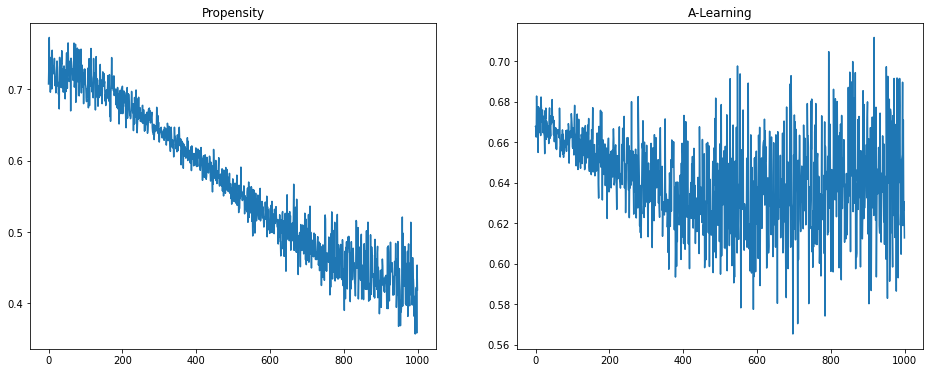

In [12]:
losses = [("Propensity", propensity_losses), ("A-Learning", a_learning_losses)]
fig, axes = plt.subplots(1, len(losses), figsize=(16, 6))
for ax, (title, l) in zip(axes, losses):
    ax.plot(range(len(l)), l)
    ax.set_title(title)